In [1]:
import sys, os
sys.path.append('..')
sys.path.append('.')

import yaml

from absl import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
import ddsp.colab.colab_utils
from ddsp.spectral_ops import compute_mel, compute_logmel
import ddsp.training
import gin
import gin.tf
import gin.tf.external_configurables

#import wandb
#resume = False
#wandb_id = 'placeholder'
logging.set_verbosity(logging.INFO)

gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

# Imports for regnet
# import math
# import os
# import random
# import shutil
# import time

# import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from Recorder import Recorder
# from data_utils import RegnetLoader, get_TSN_Data_set
# from criterion import RegnetLoss
# from model import Regnet, Modal_Response_Net
# # from test import test_checkpoint
# from contextlib import redirect_stdout
# from config import _C as config
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from tqdm import tqdm

/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


tensorflow.python.keras.regularizers.L1

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 20
plt.rcParams['font.size'] = font_size

fig_width = 6
fig_height = 4
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    print('audio shape: ', audio.shape)
    if len(audio.shape) == 2:
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    #print(np.max(logmag))
    f, t, Zxx = scipy.signal.stft(audio, train_sample_rate, nperseg=size, noverlap=int(0.75*size))
    # logmag = spectral_ops.compute_logmel(core.tf_float32(audio), lo_hz=8.0, bins=80, fft_size=size)
    # logmag = spectral_ops.compute_mfcc(core.tf_float32(audio), mfcc_bins=40, fft_size=size)
    if rotate:
        # logmag = np.rot90(np.log(np.abs(Zxx)))
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(test_samples) / train_sample_rate
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, example_secs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    #xtick_locs = (xtick_nums / example_secs * logmag.shape[1]).astype(np.int32)
    #xtick_nums = xtick_locs / logmag.shape[1] * example_secs
    #plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # plt.yticks([])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

In [3]:
# Eval with saved tensors
def generate_audio_testing(raw_gain, raw_freq, raw_dampings, modal_fir, reverb, impulse_profile,
                           gains, frequencies, dampings, modal_response,
                           noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='controls'):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D?
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    zero_freq = np.zeros_like(raw_freq)
    zero_gain = np.random.rand(1,256) #np.zeros_like(raw_gain)
    zero_damp = np.zeros_like(raw_dampings)
    
#     vid = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-10-of-47'
#     raw_gain = np.load(os.path.join(freq_path, vid+"_gains_raw.npy"))
#     raw_freq = np.load(os.path.join(freq_path, vid+"_freqs_raw.npy"))
#     raw_dampings = np.load(os.path.join(freq_path, vid+"_dampings_raw.npy"))
    
    # Get modal response from raw freqs, gains, and dampings
    irc_scratch = modal_fir.get_controls(raw_gain, raw_freq, raw_dampings)
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    
    # Get modal response from scaled (passed through get_controls) freqs, gains, dampings
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    
    print("ir: ", ir)
    print("model's output modal response: ", modal_response)
    #print("ir_scratch: ", ir_scratch)
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls' or scratch =='control':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)),
    #minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

In [4]:
# Use this method!!!!!
def generate_audio(predictions, modal_fir, reverb, impact, impulse_profile, gains, frequencies, dampings, modal_response,
                   noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='controls',
                   modal_fir_only=False):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
# Sam checkpoint is "tau_multiplier"
    # impulse_profile = prediction['impact']['signal']
    impc = impact.get_controls(predictions['magnitudes'], predictions['stdevs'], predictions['taus'], predictions['tau_multiplier'])
    impact_prof = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    
    # Generate modal FIR --> modal response (object material sound)
    # TODO: To use "raw" normally again, make sure to switch this!!
#     ir = prediction['modal_fir']['signal'] # modal response
    irc_scratch = modal_fir.get_controls(predictions['gains'], predictions['frequencies'], predictions['dampings'])
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    
    # Plotting the network output modal response
    print("Plotting convolve generated modal response")
    output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/modal_fir'
    os.makedirs(output_dir, exist_ok=True)
    begin_offset = int(train_sample_rate * 1.95)
    cutoff = int(train_sample_rate * 2.5)

    ir_plot = np.squeeze(ir_scratch) # modal response
    print(ir_plot.shape)
    ir_plot = ir_plot[begin_offset:cutoff]
    t2 = (np.arange(0, ir_plot.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
    plt.plot(t2, ir_plot)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    fig = plt.gcf()
    fig.set_size_inches(fig_width+2, fig_height)
    if no_axis:
        ax = plt.gca()
        # ax.axes.yaxis.set_visible(False)
#         ax.axes.yaxis.set_ticks([])
        plt.xticks(fontsize=font_size-6)
    fig.savefig(os.path.join(output_dir, audio_title+f'_convolve_ir-material_id_{material_id}.png'), bbox_inches='tight')
    plt.show()

    print("model's output modal response: ", modal_response)
    print("ir_scratch: ", ir_scratch)
    print("ir: ", ir)
    
    check = tf.math.equal(modal_response, ir_scratch)
    print(f"compared elements of modal response: {check}")
    assert(tf.reduce_all(check) == True)
    print(f"element-wise comparison of network output modal response and from scratch: {tf.reduce_all(check)}")
    
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    if modal_fir_only:
        print("Return audio without adding noise, acceleration sound, or reverb")
#         return ddsp.core.resample(impulse_profile, int(audio_sample_rate)*example_secs, 'linear')
    
        audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
        return audio
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)

#     noise = prediction['filtered_noise']['signal']
    audio += predictions['filtered_noise']['signal'] #noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    # acceleration_scale = prediction['acceleration_scalar']
    audio += impulse_profile * predictions['acceleration_scalar'] #acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
    # revc = prediction['reverb']['controls']['ir']
    # revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    revc_scratch = reverb.get_controls(audio, predictions['reverb_gain'], predictions['reverb_decay'])
    audio = reverb.get_signal(audio, revc_scratch['ir'])#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

In [5]:
# Load in impact profile predictions
def generate_audio_impact(predictions, modal_fir, reverb, impact, mags, taus, stdevs,
                   noise, acceleration_scale, revc, audio_sample_rate, example_secs, output_dir, scratch='raw',
                   modal_fir_only=False):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
    print("tau_bias: ", predictions['tau_bias'])
    impc_gt = impact.get_controls(predictions['magnitudes'], predictions['stdevs'], predictions['taus'], 0)#predictions['tau_bias'])
    impulse_profile_gt = impact.get_signal(impc_gt['magnitudes'], impc_gt['taus'])
    
#     mags = tf.zeros([1, 2520,1]) # test passing in all zeros for mags
#     taus = tf.zeros([1, 2520, 1])
    
    impc = impact.get_controls(mags, stdevs, taus, 0)#predictions['tau_bias'])
    impulse_profile_pred = impact.get_signal(impc['magnitudes'], impc['taus'])
    
    print("model's impact profile (has some noise) num nonzeros: ", tf.math.count_nonzero(tf.math.round(predictions['impact']['signal'])))
    print("Generated impact profile from model's output num nonzero: ", tf.math.count_nonzero(tf.math.round(impulse_profile_gt)))
    print("Predicted impact profile from loading num nonzero: ", tf.math.count_nonzero(tf.math.round(impulse_profile_pred)))
    print("difference avg: ", tf.math.reduce_mean(impulse_profile_gt - impulse_profile_pred))
    
    # Check that the impulse profile generated is same as model output
#     check = tf.math.equal(impulse_profile, impulse_profile_scratch)
#     print(f"compared elements of impulse profile: {check}")
#     if (not tf.reduce_all(check) == True):
#         diff = impulse_profile - impulse_profile_scratch
#         print("average difference: ", tf.math.reduce_mean(diff))
#         print("original impulse profile: ", impulse_profile)
# #     assert(tf.reduce_all(check) == True)
#     print(f"element-wise comparison of network output impulse profile and from scratch: {tf.reduce_all(check)}")
#     print("impulse profile shape: ", impulse_profile_scratch.shape) # force profile
    
    # Generate modal FIR --> modal response (object material sound)
    # TODO: To use "raw" normally again, make sure to switch this!!
    irc_scratch = modal_fir.get_controls(predictions['gains'], predictions['frequencies'], predictions['dampings'])
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
#     ir = modal_fir.get_signal(gains, frequencies, dampings)
    modal_response = predictions['modal_fir']['signal']
    
    # Plotting the network output modal response
    print("Plotting convolve generated modal response")
#     output_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/modal_fir'
    os.makedirs(output_dir, exist_ok=True)
    begin_offset = int(train_sample_rate * 1.95)
    cutoff = int(train_sample_rate * 2.5)

#     ir_plot = np.squeeze(ir_scratch) # modal response
#     print(ir_plot.shape)
#     ir_plot = ir_plot[begin_offset:cutoff]
#     t2 = (np.arange(0, ir_plot.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
#     plt.plot(t2, ir_plot)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     fig = plt.gcf()
#     fig.set_size_inches(fig_width+2, fig_height)
#     if no_axis:
#         ax = plt.gca()
#         # ax.axes.yaxis.set_visible(False)
# #         ax.axes.yaxis.set_ticks([])
#         plt.xticks(fontsize=font_size-6)
#     fig.savefig(os.path.join(output_dir, audio_title+f'_convolve_ir-material_id_{material_id}.png'), bbox_inches='tight')
#     plt.show()
    
    check = tf.math.equal(modal_response, ir_scratch)
    print(f"compared elements of modal response: {check}")
    assert(tf.reduce_all(check) == True)
    print(f"element-wise comparison of network output modal response and from scratch: {tf.reduce_all(check)}")
    
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile_pred, ir_scratch)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile_pred, modal_response)
    print("convolved shape: ", audio.shape)
    
    if modal_fir_only:
        print("Return audio without adding noise, acceleration sound, or reverb")
        audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
        return audio, impulse_profile_pred
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound (output from FcDecoder, from modal response pipeline)
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb (reverb_gain and reverb_decay are from FcDecoder, modal response pipeline)
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio, impulse_profile_pred

INFO:absl:Loaded checkpoint /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-high-pass-multiclass/ckpt-18000


Latest operative config used:  /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/tapping-embed-vec-len-32-high-pass-multiclass/operative_config-0.gin
n modal frequencies: 256
test samples:  441000
mel samples:  1720
Internal sampler rate:  88200
-4
4.0
/juno/u/jyau/asmr-video-to-sound/data/asmr_all/high_pass/valid/*.wav
n_out:  3
n_out:  903
input keys: ['audio']
input keys to MfccTimeRnnEncoder: ListWrapper(['audio'])
Z time steps: 2520
rnn_channels:  512
tcnn kernel:  15
Input key to EmbeddingContextEncoder: material_id
Output key to EmbeddingContextEncoder: material_embedding
autoencoder preprocessor: None
autoencoder encoder: <ddsp.training.encoders.MultiEncoder object at 0x7f63a07bdf10>
autoencoder decoder: <ddsp.training.decoders.MultiDecoder object at 0x7f63c865ac40>
autoencoder processor group: <ddsp.processors.ProcessorGroup object at 0x7f63a077fd60>
autoencoder loss objects: ListWrapper([<ddsp.losses.SpectralLoss object at 0x7f63a077fca0>])


INFO:absl:Loading model took 0.0 seconds


Audio to play is pred...
Using validation example...
audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (440320, 1)
(1, 440320)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 440320), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


Plotting original waveform
decoded_audio shape:  (1, 440320)


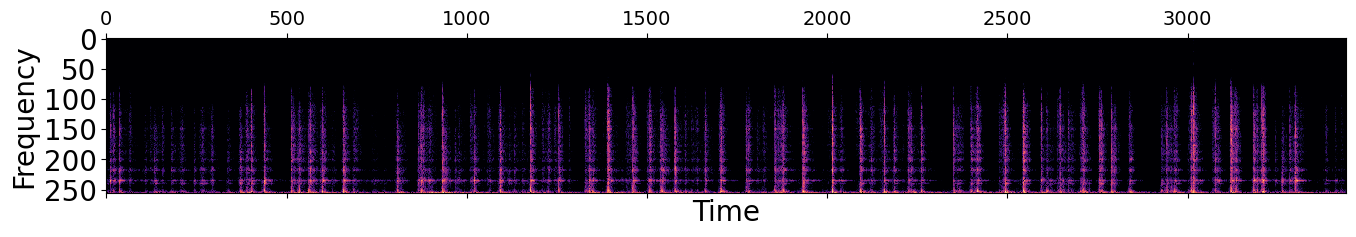

Going through autoencoder call
Input features to encoder: {'audio': <tf.Tensor: shape=(1, 440320), dtype=float32, numpy=
array([[ 2.8076172e-03,  1.5869141e-03,  8.2397461e-04, ...,
         0.0000000e+00, -3.0517578e-05, -6.1035156e-05]], dtype=float32)>, 'material_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([30], dtype=int32)>, 'video_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}
conditioning output of encoder input features: {'audio': <tf.Tensor: shape=(1, 440320), dtype=float32, numpy=
array([[ 2.8076172e-03,  1.5869141e-03,  8.2397461e-04, ...,
         0.0000000e+00, -3.0517578e-05, -6.1035156e-05]], dtype=float32)>, 'material_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([30], dtype=int32)>, 'video_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}
keyword arguments:  {'training': False}
self.z_time_steps:  2520
time_steps
Computing mfccs and latent z from input audio:  (1, 440320)
sample rate: 44100, bin: 128,

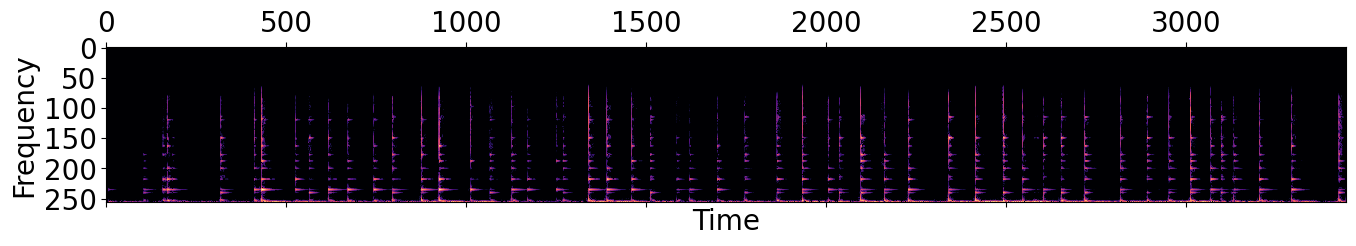

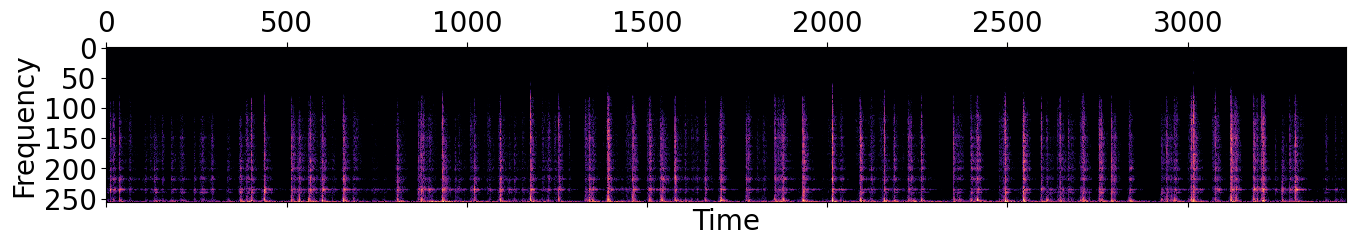

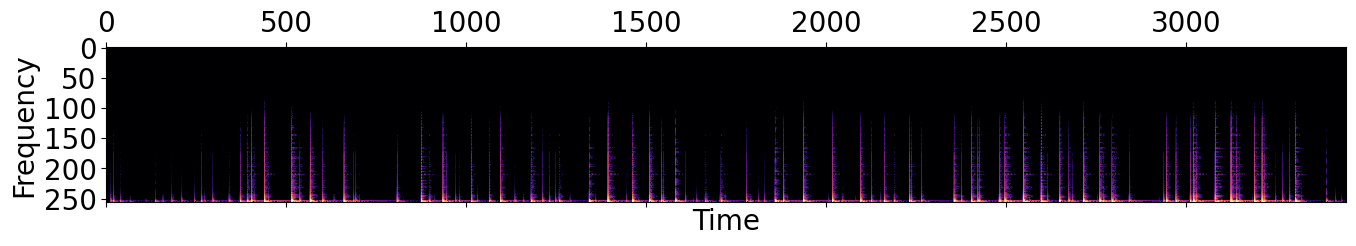

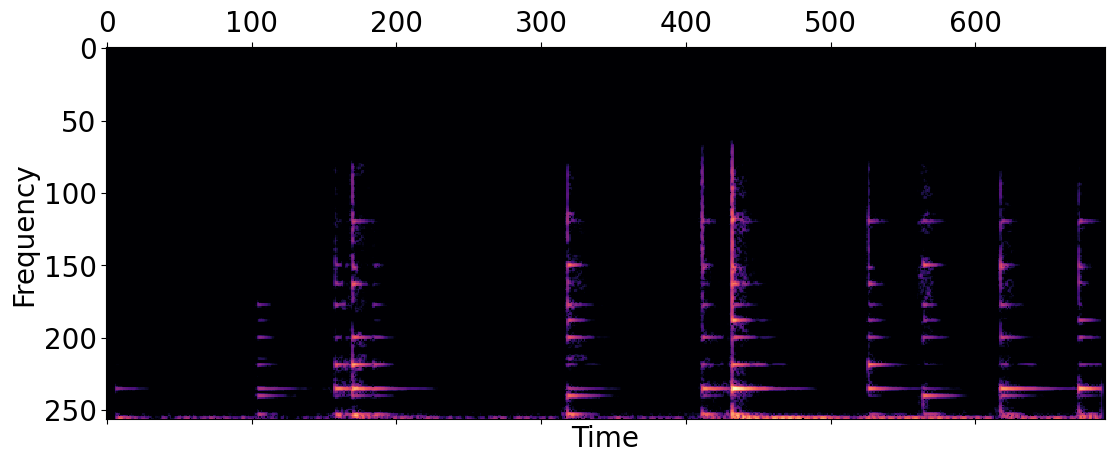

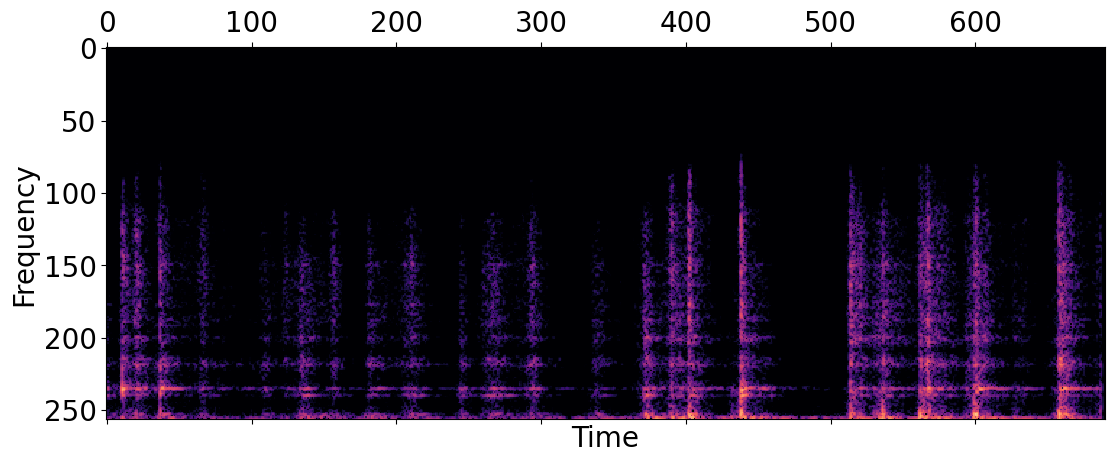

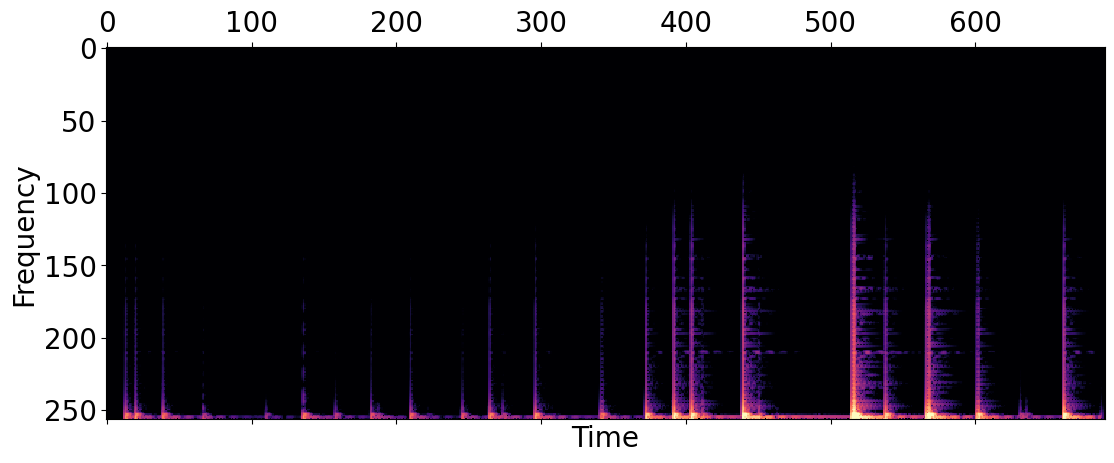

Output synth of the checkpoint from prediction[audio_synth]


Saving Diffimpact's outputted audio...
Plotting impulse profile


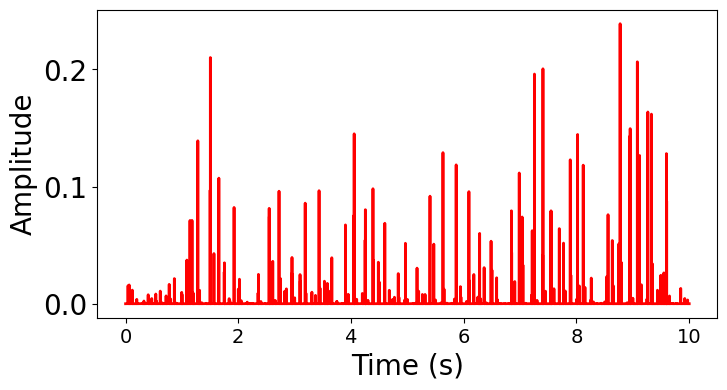

Plotting network output modal response
(176400,)


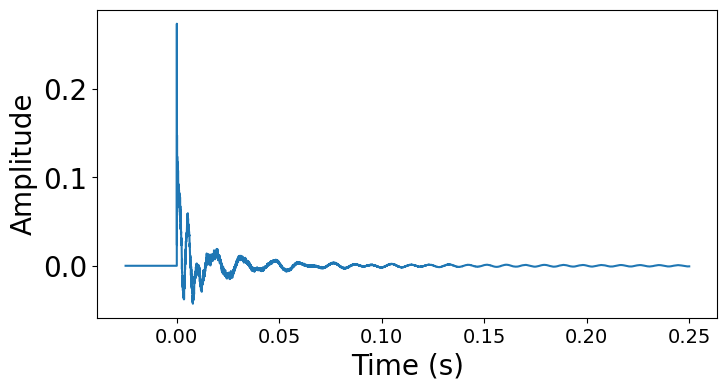

input shapes! impulse_profile: (1, 882000), ir: (1, 176400), noise: (1, 882000), revc: (1, 48000)


KeyError: 'tau_multiplier'

In [8]:
# Test out the N_MODAL_FREQUENCIES=256 checkpoint for multiclass checkpoint
from IPython.display import display
no_axis = True

# Path to eval output
#eval_output = "/juno/u/jyau/regnet/ckpt/visual_extract_pipeline_rgb_only/checkpoint_075000/eval_output"
# Full pipeline
voc_type = "ceramic-plate" #"silicone-pad" # wood-box
# vocoder_type = 'wooden-box'
# save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/'
# save_dir = f"/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/sam-no-high-pass-multiclass"
# save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/sam-diffimpact-ckpts-multiclass/'
# save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/1hr-{vocoder_type}'
# save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/checkpoints/{voc_type}' # Sam's checkpoint
# save_dir = '/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/train-all'
ckpt_path = "/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/"
# save_dir = os.path.join(ckpt_path, "sam-diffimpact-ckpts-multiclass")
# save_dir = os.path.join(ckpt_path, "tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-verify-last")
# save_dir = os.path.join(ckpt_path, "tapping-embed-vec-len-32-high-pass-multiclass")
# save_dir = os.path.join(ckpt_path, "tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-last-training")
# save_dir = os.path.join(ckpt_path, "sam-ceramic-plate-waveglow-mel-spec-single-ckpt")
save_dir = os.path.join(ckpt_path, "tapping-embed-vec-len-32-high-pass-multiclass")
example_secs = 10
offset_secs = 0

latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
# latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
print(f"n modal frequencies: {n_modal_freq}")
#gin.config.bind_parameter('%N_MODAL_FREQUENCIES', 64)
#n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
#print(f"n modal frequencies: {n_modal_freq}")

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

audio_sample_rate = train_sample_rate

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)
print("test samples: ", test_samples)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)

# Change the MFCC mel samples
new_mel_samples = example_secs * 172
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.mel_samples', new_mel_samples)
print("mel samples: ", new_mel_samples)
try:
    # Change internal sample rate to be same as audio sample rate
#     gin.config.bind_parameter('%INTERNAL_SAMPLE_RATE', gin.config.query_parameter('%AUDIO_SAMPLE_RATE'))
    
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    print("Internal sampler rate: ", train_internal_sample_rate)
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

model = ddsp.training.models.get_model()
model.restore(save_dir)

# Loading and processing audio
MAX_WAV_VALUE = 32768.0

audio_type = 'pred'
example_type = 'val'
# audio_title = "FFmXszcvt58-003-0010" # ceramic cup
# audio_title = "IlJYaR2D7GU-008-0010" # leather bag
audio_title = "sIgkTYTWPz8-004-0000"
# audio_title = "sIgkTYTWPz8-004-0030"
# audio_title = "IlJYaR2D7GU-001-0000"
# audio_title = "IlJYaR2D7GU-012-0020"
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-silicon-coaster-29-of-48'
# audio_title = "ASMR_Brain_Penetrating_3D_Tapping_No_Talking-101-of-240"
# audio_title = "compilation_final"
#audio_title = "The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-plastic-mold-2-16-of-18"
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-34-of-47'
# audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-wooden-box-42-of-45"
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
#audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
try:
    if audio_type == "pred":
        print("Audio to play is pred...")
        if example_type == "train":
#             audio = tf.io.read_file(f"/juno/u/jyau/asmr-video-to-sound/ckpt/impact_profile_mel_spec_backprop/best_regnet_last_force_ckpt_train_subset/checkpoint_200000_outputs/TrainAll/{audio_title}_synthesis.wav")
            audio = tf.io.read_file(f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/train_subset_last_ckpt_inf/checkpoint_100000_outputs/TrainAll/{audio_title}_synthesis.wav')
        else:
            print("Using validation example...")
#             audio = tf.io.read_file(f"/juno/u/jyau/asmr-video-to-sound/ckpt/impact_profile_mel_spec_backprop/best_regnet_last_force_ckpt_eval/checkpoint_200000_outputs/TrainAll/{audio_title}_synthesis.wav")
            audio = tf.io.read_file(f'/juno/u/jyau/regnet/ckpt/regnet_tapping_materials_medium_batch/val_last_ckpt_inference/checkpoint_100000_outputs/TrainAll/{audio_title}_synthesis.wav')
    else:
#     audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/tapping/materials/audio_10s_44100hz/{audio_title}.wav')
#     audio = tf.io.read_file(f"/juno/u/jyau/asmr-video-to-sound/ckpt/impact_components_material_classification_init/last_ckpt/waveglow_all/waveglow_all/{audio_title}_synthesis.wav")
        audio = tf.io.read_file(f'/juno/u/jyau/asmr-video-to-sound/data/asmr_all/valid/{audio_title}.wav')
#     audio = tf.io.read_file(f'/juno/u/jyau/asmr-video-to-sound/data/asmr_all/high_pass/valid/{audio_title}.wav')
#     audio = tf.io.read_file(f'/juno/u/jyau/regnet/ckpt/regnet_baseline_asmr_by_material/val_inf_last_ckpt_waveglow_trainall/{audio_title}_synthesis.wav')
#     audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/train/{audio_title}.wav')
except Exception as ex:
    audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/val/{audio_title}.wav')
# audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/ASMR_Brain_3D_Tapping/audio_10s_44100hz/{audio_title}.wav')
#compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
#orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio_init, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio_init.shape)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio_init[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)

# Original audio
gt = tf.io.read_file(f'/juno/u/jyau/asmr-video-to-sound/data/asmr_all/valid/{audio_title}.wav')
gt_init, _ = tf.audio.decode_wav(gt, desired_channels=1)
gt_audio = tf.expand_dims(tf.squeeze(gt_init[offset_samples:(offset_samples + test_samples)]), axis=0)


material_id = 30
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[material_id], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
display(IPython.display.Audio(data=decoded_audio, rate=int(train_sample_rate)))
display(IPython.display.Audio(data=gt_audio, rate=int(train_sample_rate)))

# Plotting audio waveforms
print("Plotting original waveform")
output_dir = save_dir
# plot_spec(decoded_audio, 512)
print("decoded_audio shape: ", decoded_audio.shape)
ddsp.colab.colab_utils.specplot(decoded_audio, size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+'_audio_input_orig_audio.png'), bbox_inches='tight')
plt.show()

# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction = model(next(iter(test_input)), training=False)
print(f"prediction keys: {prediction.keys()}")
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)
ddsp.colab.colab_utils.specplot(gt_audio[:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(gt_audio[:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()

print("Output synth of the checkpoint from prediction[audio_synth]")
display(IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(train_sample_rate)))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))
print("Saving Diffimpact's outputted audio...")
audio_path = f"{os.path.join(save_dir, audio_title+f'_{audio_type}_pred_reg_waveglow_all_audio_input_synth_'+ str(material_id) +'.wav')}"
transpose_aud = np.transpose(prediction['audio_synth'][:1, :].numpy())
scipy.io.wavfile.write(audio_path, audio_sample_rate,
      np.array(32767 * transpose_aud / np.max(np.abs(prediction['audio_synth']))).astype('int16'))

# def save_audio(audio, output_prefix):
#     for i in range(audio.shape[0]):
#         filename = os.path.join(output_dir, '%s%s'%(output_prefix, source_files[i]))
#         scipy.io.wavfile.write(filename, fs, np.array(32767 * audio[i, :] / np.max(np.abs(audio))).astype(np.int16))

# Generate audio by replacing the frequency with eval
#samplerate, data = wavfile.read(wav_fname)
# print(f"number of channels = {data.shape[1]}")
# number of channels = 2
# length = data.shape[0] / samplerate
# print(f"length = {length}s")
# length = 0.01s

# modal_fir = ddsp.synths.ModalFIR(n_samples=int(fs*sample_factor/1.0), sample_rate=int(fs*sample_factor),
#                             initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
# Note that clip is the data in example above, so clip.shape[0] is the length of the audio: seconds * sample rate
# impact = ddsp.synths.Impact(sample_rate=int(fs*sample_factor), n_samples=int(clip.shape[0]*sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
# reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)
# Initialize modules
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(sample_factor * train_sample_rate), sample_rate=int(sample_factor * train_sample_rate),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
# Impact synth can include_noise=True, which adds random noise based on stdevs, or not
impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate),
                            n_samples=int(sample_factor * (example_secs * audio_sample_rate)),
                            max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=False)
# impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate), n_samples=int(sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))

# Plotting impact/force profile
print("Plotting impulse profile")
# output_dir = save_dir
output_dir = os.path.join(save_dir, f'impact_profile_noaxis')
os.makedirs(output_dir, exist_ok=True)

t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * sample_factor) #2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red', linewidth=2)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
    
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
fig.savefig(os.path.join(output_dir, audio_title+f'_audio_input_impact_signal_only-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Plotting the network output modal response
print("Plotting network output modal response")
output_dir = os.path.join(save_dir, f'modal_fir')
os.makedirs(output_dir, exist_ok=True)
begin_offset = int(train_sample_rate * 1.95)
cutoff = int(train_sample_rate * 2.5)

ir_plot = np.squeeze(prediction['modal_fir']['signal']) # modal response
print(ir_plot.shape)
ir_plot = ir_plot[begin_offset:cutoff]
t2 = (np.arange(0, ir_plot.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
plt.plot(t2, ir_plot)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_audio_input_ir-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")

audio_final = generate_audio(prediction, modal_fir, reverb, impact, impulse_profile,
                             prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='raw',
                             modal_fir_only=False)

print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
# display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))
# scipy.io.wavfile.write(filename, fs, np.array(32767 * audio[i, :] / np.max(np.abs(audio))).astype(np.int16))
audio_path = f"{os.path.join(save_dir, audio_title+f'_{audio_type}_reg_waveglow_allaudio_input_convolve_'+ str(material_id) +'.wav')}"
transpose_aud = np.transpose(audio_final[:1, :].numpy())
scipy.io.wavfile.write(audio_path, audio_sample_rate,
      np.array(32767 * transpose_aud / np.max(np.abs(prediction['audio_synth']))).astype('int16'))

test_audio = tf.math.equal(prediction['audio_synth'], audio_final)
print("audio element-wise check: ", tf.reduce_any(test_audio))

if not tf.reduce_all(tf.math.equal(prediction['audio_synth'], audio_final)):
    print(f"network audio synth: {prediction['audio_synth']}")
    print(f"convolve output: {audio_final}")
    print(f"differences: {prediction['audio_synth'] - audio_final}")
    print('average of the differences: ', tf.math.reduce_mean(prediction['audio_synth'] - audio_final))

# Plotting audio waveforms
print("Plotting audio synth waveform")
output_dir = os.path.join(save_dir, f'final_audio')
os.makedirs(output_dir, exist_ok=True)
# plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_audio_input_synth_wav-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()


# Plotting audio waveforms
print("Plotting convolve waveform")
# plot_spec(audio_final[:1, :train_sample_rate*2], 512)
ddsp.colab.colab_utils.specplot(audio_final[:1, :train_sample_rate*2], size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_audio_input_convolve_wav-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Plotting audio waveforms
print("Audio title: ", audio_title)
print("Plotting impact profile waveform. shape: ", impulse_profile.shape)
# plot_spec(audio_final[:1, :train_sample_rate*2], 512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(ddsp.core.resample(impulse_profile[:1, :], int(audio_sample_rate)*example_secs, 'linear'), size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
#     ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_audio_input_impulse_profile_waveform.png'), bbox_inches='tight')
plt.show()


output_dir = os.path.join(save_dir, f'final_audio')
os.makedirs(output_dir, exist_ok=True)

plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+1, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, audio_title+f'_audio_input_waveform-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()
plt.rcParams.update({
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.2),
})
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, audio_title+f'_audio_input_waveform_translucent-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()

# Check shape of the impact info
print(f"mags shape: {prediction['magnitudes'].shape}")
print(f"stdevs shape: {prediction['stdevs'].shape}")
print(f"taus shape: {prediction['taus'].shape}")
print("Audio title: ", audio_title)

In [ ]:
# Get audio with predicted force profile
"""
acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir']
"""
# material_id = 124
empty = tf.zeros_like(decoded_audio)  #tf.zeros([1, 1720, 80])
# test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[material_id], 'video_id':[0]}).batch(2)
test_empty_input = tf.data.Dataset.from_tensor_slices({'audio':empty, 'mel_spec':empty, 'material_id':[material_id], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
# display(IPython.display.Audio(data=empty, rate=int(train_sample_rate)))
preds = model(next(iter(test_empty_input)), training=False)

# Get audio with predicted force profile components
# Path to impact components output
if audio_type == "pred":
    print("Using predicted force profile components...")
    impact_comp_dir = f"/juno/u/jyau/asmr-video-to-sound/ckpt/impact_profile_mel_spec_backprop/last_ckpt_eval/impact_components/"
else:
    print("Getting ground truth components...")
    impact_comp_dir = f"/juno/u/jyau/regnet/data/features/tapping/materials/tapping-embed-vec-len-32-no-regularizer-high-pass-multiclass-verify-last-outputs/impulse_profile_components/"
#     impact_comp_dir = f"/juno/u/jyau/regnet/data/features/tapping/materials/sam-ckpts-multiclass-diffimpact-outputs/impulse_profile_components/"


# Load the predicted force profile components
mags = np.load(os.path.join(impact_comp_dir, f'{audio_title}_magnitudes.npy'))
print(mags.shape)
if len(mags.shape) < 3:
    mags = tf.expand_dims(tf.convert_to_tensor(mags), axis=0)
else:
    mags = tf.convert_to_tensor(mags)

taus = np.load(os.path.join(impact_comp_dir, f'{audio_title}_taus.npy'))
if len(taus.shape) < 3:
    taus = tf.expand_dims(tf.convert_to_tensor(taus), axis=0)
else:
    taus = tf.convert_to_tensor(taus)

stdevs = np.load(os.path.join(impact_comp_dir, f'{audio_title}_stdevs.npy'))
if len(stdevs.shape) < 3:
    stdevs = tf.expand_dims(tf.convert_to_tensor(stdevs), axis=0)
else:
    stdevs = tf.convert_to_tensor(stdevs)
    
print(f"mags shape: {mags.shape}, taus shape: {taus.shape}, stdevs shape:{stdevs.shape}")
print("num non-zeroes in pred taus: ", tf.math.count_nonzero(tf.math.round(taus)))
print("pred stdevs: ", tf.math.count_nonzero(tf.math.round(stdevs))) # only noise
print("pred magnitudes non zeros: ", tf.math.count_nonzero(tf.math.round(mags)))

impact_audio, impact_profile = generate_audio_impact(preds, modal_fir, reverb, impact, mags, taus, stdevs,
                   noise, acceleration_scale, revc, audio_sample_rate, example_secs, output_dir, scratch='raw',
                   modal_fir_only=True)

print(f"impact audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
display(IPython.display.Audio(data=impact_audio, rate=int(train_sample_rate)))

print("Plotting spectrograms...")
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(impact_audio[:1, :], size=512)
ddsp.colab.colab_utils.specplot(ddsp.core.resample(impact_profile[:1, :], int(audio_sample_rate)*example_secs, 'linear'), size=512)

# print("Plotting the force profile on time dim (seconds)")
# output_dir = os.path.join(save_dir, f'impact_profile_noaxis')
# os.makedirs(output_dir, exist_ok=True)
# # t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
# t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * sample_factor)
# plt.plot(t2, np.squeeze(impact_profile[:1, :]), c='red', linewidth=2)
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# if no_axis:
#     ax = plt.gca()
#     # ax.axes.yaxis.set_visible(False)
# #     ax.axes.yaxis.set_ticks([])
#     plt.xticks(fontsize=font_size-6)
    
# fig = plt.gcf()
# fig.set_size_inches(fig_width+2, fig_height)
# fig.savefig(os.path.join(output_dir, audio_title+f'_{audio_type}_audio_input_force_profile_impact_signal_only-material_id_{material_id}.png'), bbox_inches='tight')
plt.show()
print("Done")

# Save convolved audio
# The write function in scipy.io.wavfile expects the input array to have the shape (num_samples, num_channels)
# https://stackoverflow.com/questions/40822877/scipy-io-cant-write-wavfile
# For example shape (2, 40000) is incorrect, need transposing
# audio_path = f"{os.path.join(save_dir, audio_title+f'_{audio_type}_convolve_impact_pred'+ str(material_id) +'.wav')}"
# transposed_audio = np.transpose(impact_audio.numpy())
# scipy.io.wavfile.write(audio_path, audio_sample_rate,
#       np.array(32767 * transposed_audio / np.max(np.abs(impact_audio))).astype('int16'))


In [ ]:
# Get modal response with the audio dspy library
# import audio_dspy as adsp
# mel = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/melspec_10s_44100hz/{vid}_mel.npy')
# print(f'mel shape: {mel.shape} and audio sample rate: {audio_sample_rate}')
# freqs, gains = adsp.find_freqs(decoded_audio_init, audio_sample_rate, plot=True)

# obj = {}
# obj['frequencies'] = freqs
# obj['gains'] = gains
# obj['dampings'] = prediction['dampings']

# # Generate modal response, and convolve with the force profile, noise, and reverb
# print(f"freqs: {freqs.shape}, gains: {gains.shape}, damping: {prediction['dampings'].shape} noise: {noise.shape}, revc: {revc.shape}")
# audio_final = generate_audio(obj, modal_fir, reverb, impulse_profile,
#                              prediction['modal_fir']['controls']['gains'],
#                              prediction['modal_fir']['controls']['frequencies'],
#                              prediction['modal_fir']['controls']['dampings'],
#                              ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='raw')
# print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
# display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))

In [ ]:
# scratch = 'else'
# # Generate modal FIR --> modal response (object material sound)
# modal_response = prediction['modal_fir']['signal']
# irc_scratch = modal_fir.get_controls(prediction['gains'], prediction['frequencies'], prediction['dampings'])
# ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
# #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
# ir = modal_fir.get_signal(prediction['modal_fir']['controls']['gains'],
#                           prediction['modal_fir']['controls']['frequencies'],
#                           prediction['modal_fir']['controls']['dampings'])
# print("ir: ", ir)
# print("model's output modal response: ", modal_response)
# print("ir_scratch: ", ir_scratch)
# # Convolve together for modal vibration sounds
# # Convolve together for modal vibration sounds
# if scratch == 'raw':
#     audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
# elif scratch == 'controls':
#     audio = ddsp.core.fft_convolve(impulse_profile, ir)
# else:
#     audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
# print("convolved shape: ", audio.shape)

# # Generate and add time constant noise
# audio += noise
# print("after adding noise: ", audio.shape)

# # Add acceleration sound
# audio += impulse_profile * acceleration_scale
# print("after acceleration sound: ", audio.shape)

# # Add reverb
# audio = reverb.get_signal(audio, revc)#revc['ir'])
# print("after reverb: ", audio.shape)

# # Downsample from internal sampling rate to original recording sampling rate
# print("audio sample rate: ", audio_sample_rate)
# audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
# display(IPython.display.Audio(data=audio, rate=int(train_sample_rate)))

In [ ]:
# TODO: only after merging the regnet and ddsp models, otherwise they're using two different envs currently
# Load the trained frequency decoder model
# model = Modal_Response_Net()
# print("Initialized model")

# model.load_checkpoint(config.checkpoint_path)

# # Load data
# print("Getting the images to be stacked...")
# args.test_list = './filelists/asmr_by_material_1hr_train.txt' 
# trainset = get_TSN_Data_set(args)
# args.test_list = './filelists/asmr_by_material_1hr_test.txt'
# valset = get_TSN_Data_set(args)

# train_loader = DataLoader(trainset, num_workers=0, shuffle=True,
#                           batch_size=config.batch_size, pin_memory=False,
#                           drop_last=True)
# test_loader = DataLoader(valset, num_workers=0, shuffle=False,
#                          batch_size=config.batch_size, pin_memory=False)
# print("Check number of train examples: ", len(trainset))
# print("Check number of train loader examples: ", len(train_loader))
# assert(len(trainset) > 0)
# assert(len(train_loader) > 0)

In [ ]:
# SpecGAN Vladimir evaluated sample check
# mel_check = np.load('/juno/u/jyau/SpecVQGAN/logs/2021-12-11T17-05-22_asmr_by_material_transformer/samples_None/VAS_validation/cls_1/ASMR_Addictive_Tapping_1_Hr_No_Talking-ceramic-plate-38-of-41_mel_sample_0.npy')
# print(mel_check.shape)
# ddsp.colab.colab_utils.specplot(mel_check, size=512)

# plt.figure()
# plt.imshow(mel_check,aspect='auto', origin='lower')
# plt.show()
#display(IPython.display.Audio(data=check, rate=int(44100)))